In [1]:
%matplotlib inline
import findspark
import os

In [2]:
findspark.init(os.environ['SPARK_HOME'])

In [20]:
import pyspark 
import pandas as pd
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import *  
import matplotlib.pyplot as plt

In [4]:
# creamos la sesión de spark
spark = SparkSession\
.builder\
.appName("spark_Parte3")\
.getOrCreate()

# 3.1 Cargar el CSV en Spark

In [5]:
profecoDf = spark.read.format("csv")\
        .option("delimiter", "|")\
        .option("header","true")\
        .option("inferSchema", "true")\
        .load("data/prueba_final.csv")

In [427]:
profecoDf.columns

['producto',
 'presentacion',
 'marca',
 'categoria',
 'catalogo',
 'precio',
 'fecharegistro',
 'cadenacomercial',
 'giro',
 'nombrecomercial',
 'direccion',
 'estado',
 'municipio',
 'latitud',
 'longitud']

In [428]:
profecoDf.count()

10000000

In [429]:
profecoDf.show(5)

+--------------------+--------------------+--------+----------------+----------------+------+-------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+-------+---------+
|            producto|        presentacion|   marca|       categoria|        catalogo|precio|      fecharegistro|   cadenacomercial|      giro|     nombrecomercial|           direccion|          estado|           municipio|latitud| longitud|
+--------------------+--------------------+--------+----------------+----------------+------+-------------------+------------------+----------+--------------------+--------------------+----------------+--------------------+-------+---------+
|cuaderno forma it...|96 hojas pasta du...|estrella|material escolar|utiles escolares|   259|2011-05-18 00:00:00|abastecedora lumen|papelerias|abastecedora lume...|cannes no 6 esq c...|distrito federal|tlalpan          ...|1929699|-99125417|
|            crayones|caja 12 ce

In [430]:
profecoDf.dtypes

[('producto', 'string'),
 ('presentacion', 'string'),
 ('marca', 'string'),
 ('categoria', 'string'),
 ('catalogo', 'string'),
 ('precio', 'int'),
 ('fecharegistro', 'timestamp'),
 ('cadenacomercial', 'string'),
 ('giro', 'string'),
 ('nombrecomercial', 'string'),
 ('direccion', 'string'),
 ('estado', 'string'),
 ('municipio', 'string'),
 ('latitud', 'string'),
 ('longitud', 'string')]

# 3.2 Guardar como .parquet

In [7]:
profecoDf.write.parquet('profecoFinal.parquet')

# 3.3 Cargar parquet en Spark

In [8]:
profecoDfParquet = spark.read.format('parquet')\
        .load("profecoFinal.parquet")

In [9]:
profecoDfParquet.show(1)

+-------------------+--------------------+-------------------+--------------------+--------+------+-------------------+------------------+--------------------+--------------------+--------------------+-------+--------------------+--------+----------+
|           producto|        presentacion|              marca|           categoria|catalogo|precio|      fecharegistro|   cadenacomercial|                giro|     nombrecomercial|           direccion| estado|           municipio| latitud|  longitud|
+-------------------+--------------------+-------------------+--------------------+--------+------+-------------------+------------------+--------------------+--------------------+--------------------+-------+--------------------+--------+----------+
|panales desechables|paquete 40 piezas...|chicolastic kiddies|arts de papel p/h...| basicos|  1198|2011-04-19 00:00:00|comercial mexicana|tienda de autoser...|comercial mexican...|rafael sancio no5...|jalisco|guadalajara      ...|20676116|-1034295

In [10]:
#Poner disponible para ejecutar sentencias SQL en Spark
profecoDfParquet.createOrReplaceTempView("profecoDf")

In [12]:
print(profecoDf.columns)

['producto', 'presentacion', 'marca', 'categoria', 'catalogo', 'precio', 'fecharegistro', 'cadenacomercial', 'giro', 'nombrecomercial', 'direccion', 'estado', 'municipio', 'latitud', 'longitud']


In [13]:
# Filtrar unicamente medicamentos
spark.sql("SELECT * FROM profecoDf WHERE categoria LIKE '%medicamentos%' AND marca NOT IN ('s/m','sin marca')").createOrReplaceTempView("profecoDfMed")

In [14]:
# Eliminar Vista para liberar RAM
spark.catalog.dropTempView("profecoDf")

### 3.3 Pregunta 1 ¿Cuańtas marcas diferentes tiene tu categoría?

In [438]:
spark.sql("SELECT COUNT(*) AS total FROM (SELECT DISTINCT(marca) FROM profecoDfMed)").toPandas()

,total
0,75


### 3.3 Pregunta 2 ¿Cuál es la marca con mayor precio? ¿En qué estado?

In [439]:
spark.sql("SELECT marca, precio, estado FROM profecoDfMed ORDER BY precio DESC LIMIT 1").toPandas()

,marca,precio,estado
0,"glaxo wellcome mexico, sa de cv",211275,aguascalientes


### 3.3 Pregunta 3 ¿Cuál es la marca con menor precio en CDMX? (en aquel entonces Distrito Federal)

In [440]:
spark.sql("SELECT marca, precio, estado FROM profecoDfMed WHERE estado='distrito federal' ORDER BY precio ASC LIMIT 1").toPandas()

,marca,precio,estado
0,medimart gi valdecasas,5,distrito federal


### 3.3 Pregunta 4 ¿Cuál es la marca con mayores observaciones?

In [441]:
spark.sql("SELECT marca, COUNT(marca) AS observaciones FROM profecoDfMed GROUP BY marca ORDER BY COUNT(marca) DESC LIMIT 1").toPandas()

,marca,observaciones
0,"aventis pharma, sa de cv",47979


### 3.3 Pregunta 5 ¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [442]:
# Obtener el año máximo
maxYears =spark.sql("SELECT MAX(year(fecharegistro)) AS year FROM profecoDfMed").rdd.flatMap(lambda x: x).collect()
maxYears=str(years[0])

In [443]:
spark.sql("SELECT DISTINCT marca, MAX(year(fecharegistro)) AS maxYear  \
          FROM profecoDfMed \
          GROUP BY marca").createOrReplaceTempView("profecoDistMarcYear")

In [444]:
# Marca y año que desapareció
spark.sql("SELECT marca, maxYear+1 AS desYear FROM profecoDistMarcYear WHERE maxYear<{0}".format(maxYear)).toPandas()

,marca,desYear
0,alpharma,2012
1,gi antibioticos de puebla,2012
2,medimart gi quimica y farmacia,2012
3,gi biomep,2012
4,farmacom - g i apotex,2012
5,g i protein,2012
6,farmacom - gi quimica y farmacia,2012
7,g i hormona,2012
8,farmacom gi apotex,2012
9,"mead johnson de mexico, sa de cv",2012


In [445]:
# Crear Vista profecoDistMarcYear
profecoDfParquet.createOrReplaceTempView("profecoDistMarcYear")

### 3.3 Pregunta 6 ¿Ha dejado de existir alguna marca durante los años que tienes? ¿Cuál? ¿Cuándo desapareció?

In [469]:
spark.sql("SELECT MAX(precio)||YEAR(fecharegistro)||estado FROM profecoDistMarcYear GROUP BY estado, YEAR(fecharegistro)").show()

+------------------------------------------------------------------------------------------------------+
|concat(concat(CAST(max(precio) AS STRING), CAST(year(CAST(fecharegistro AS DATE)) AS STRING)), estado)|
+------------------------------------------------------------------------------------------------------+
|                                                                                   17928372012tlaxcala|
|                                                                                  63749152012queretaro|
|                                                                                  15299152011aguasc...|
|                                                                                  30599152011queretaro|
|                                                                                    16999152012durango|
|                                                                                  42499152011coahui...|
|                                                      

In [23]:
datos_grafica = spark.sql("SELECT MAX(precio), estado, YEAR(fecharegistro) FROM profecoDfMed GROUP BY estado, YEAR(fecharegistro)").collect()

In [24]:
df=pd.DataFrame(datos_grafica)

In [25]:
df.columns=["precio_maximo","estado","year"]

In [29]:
df

,precio_maximo,estado,year
0,168095,tlaxcala,2012
1,145756,queretaro,2012
2,211275,aguascalientes,2011
3,179554,queretaro,2011
4,153413,durango,2012
5,174998,coahuila de zaragoza,2011
6,168992,quintana roo,2011
7,153413,sonora,2011
8,147808,hidalgo,2012
9,128949,tabasco,2012


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/pandas/plotting/_core.py:1001: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=2011.0, right=2011.0
  ax.set_xlim(left, right)


estado
aguascalientes                     AxesSubplot(0.125,0.125;0.775x0.755)
coahuila de zaragoza               AxesSubplot(0.125,0.125;0.775x0.755)
colima                             AxesSubplot(0.125,0.125;0.775x0.755)
distrito federal                   AxesSubplot(0.125,0.125;0.775x0.755)
durango                            AxesSubplot(0.125,0.125;0.775x0.755)
guanajuato                         AxesSubplot(0.125,0.125;0.775x0.755)
hidalgo                            AxesSubplot(0.125,0.125;0.775x0.755)
jalisco                            AxesSubplot(0.125,0.125;0.775x0.755)
mexico                             AxesSubplot(0.125,0.125;0.775x0.755)
michoacan de ocampo                AxesSubplot(0.125,0.125;0.775x0.755)
nuevo leon                         AxesSubplot(0.125,0.125;0.775x0.755)
oaxaca                             AxesSubplot(0.125,0.125;0.775x0.755)
puebla                             AxesSubplot(0.125,0.125;0.775x0.755)
queretaro                          AxesSubplot(0.125,0.12

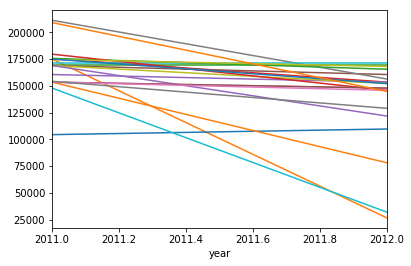

In [33]:
fig , ax = plt.subplots()
df.groupby("estado").plot(x="year",y="precio_maximo", ax=ax,legend = False)